In [1]:
import keras
from keras import models
from keras import layers
from keras.datasets import boston_housing

import numpy as np

import matplotlib.pyplot as plt

# Predicting house prices: a regression example

In regression problems we try to predict a _continuous value_ instead of a discrete label.

## The Boston Housing Price dataset


Differences from our two previous examples
- very few data points (506, 404 for training and 102 for testing)
- each feature in the input data has a different scale

In [2]:
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()
print("Train data shape: ", train_data.shape)
print("Test data shape:  ", test_data.shape)

65536/57026 [==================================] - 0s 0us/step
Train data shape:  (404, 13)
Test data shape:   (102, 13)


In [7]:
import pandas as pd
pd.DataFrame(train_data).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


The data comprises the following 13 features:

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of black people by town.
13. Proportion of "lower status" population.

The targets are the median values of owner-occupied homes, in thousands of dollars.

Lecturer note: the "median" is computed over a certain area (census tract).

In [3]:
print(train_targets[0])
print(np.min(train_targets))
print(np.max(train_targets))
print(np.mean(train_targets))

15.2
5.0
50.0
22.395049504950492


## Preparing the data

It would be problematic to feed into a neural network values that all take wildly different ranges.
The network might be able to automatically adapt to such heterogeneous data,
but it would definitely make learning more difficult. (Note: as we saw with the MNIST example)

A widespread best practice to deal with such data is to do feature-wise normalization:
for each feature in the input data (a column in the input data matrix),
we will subtract the mean of the feature and divide by the standard deviation,
so that the feature will be centered around 0 and will have a unit standard deviation.

### Lecturer note

Strictly speaking _normalization_ means that we scale all the data to the same interval, typically [0,1] or [-1,1].

In _min-max normalization_ we first subtract the minimum value from each element;
minimum element is mapped to 0 and maximum element to max-min (> 0).

In _mean normalization_ we first subtract the mean --- thus getting both positive and negative values.

In both cases, we _rescale_ the centered data by dividing it by the difference of max and min --- the _scale_.
After this, our values are either in range [0,1] (min-max) or [-1,1] (mean).

Numpy comes with "peak-to-peak" operation `ptp`, which can be used to compute the difference of maximum and minimum value (we could, of course, extract the max and min and compute the scale ourselves).

[Numpy mean](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.mean.html) --- like `min`, `max` and `ptp` --- flattens its argument by default.
We don't want to compute the minimum or range of all feature values but the minimum and range of each feature separately.
Hence, we must tell Numpy the axis over which we average etc. on.

The example below hopefully helps to understand this. Think the `axis`parameter as telling which axis has the `:` as its index.

In [11]:
a = np.array([
    [  1,   20], 
    [300, 4000]])

print('All elements: min & mean')
print('Min: ', np.min(a))
print('Max: ', np.max(a))
print('Mean:', np.mean(a), '\n')

print('Iterate over first axis (rows)')
print('Column 1 = ', a[:,0])
print('Column 2 = ', a[:,1])
print('Max: ', np.max(a, axis=0))
print('Mean:', np.mean(a, axis=0), '\n')

print('Iterate over second axis (columns)')
print('Row 1 = ', a[0,:])
print('Row 2 = ', a[1,:])
print('PTP: ', np.ptp(a, axis=1))
print('Mean:', np.mean(a, axis=1))

All elements: min & mean
Min:  1
Max:  4000
Mean: 1080.25 

Iterate over first axis (rows)
Column 1 =  [  1 300]
Column 2 =  [  20 4000]
Max:  [ 300 4000]
Mean: [ 150.5 2010. ] 

Iterate over second axis (columns)
Row 1 =  [ 1 20]
Row 2 =  [ 300 4000]
PTP:  [  19 3700]
Mean: [  10.5 2150. ]


Function `minmax_normalize` below is quite tightly written. Try figuring out what it exactly does --- apart from rescaling all data to [0,1].

In [12]:
def minmax_normalize(d):
    d -= np.min(d, axis=0) #compute feature-wise minima and subtract them from feature values
    d /= np.ptp(d, axis=0) #compute ranges and divide by them
    return d

In [13]:
# making a work copy of training data (the routines seem to modify their argument...)
foobar = np.copy(train_data)

normalized_data = minmax_normalize(foobar)

print(train_data[2])
print(normalized_data[2])

[4.89822e+00 0.00000e+00 1.81000e+01 0.00000e+00 6.31000e-01 4.97000e+00
 1.00000e+02 1.33250e+00 2.40000e+01 6.66000e+02 2.02000e+01 3.75520e+02
 3.26000e+00]
[0.05498378 0.         0.64662757 0.         0.50617284 0.2728505
 1.         0.02117799 1.         0.91395793 0.80851064 0.94608906
 0.04221854]


Similar implementation for mean normalization:

In [14]:
# rescales all data to [-1,1]
def mean_normalize(d):
    d -= np.mean(d, axis=0) #compute means and subtract them
    d /= np.ptp(d, axis=0)  #compute ranges and divide by them
    return d

In [15]:
foobar = np.copy(train_data)

normalized_data = mean_normalize(foobar)

print(train_data[2])
print(normalized_data[2])

[4.89822e+00 0.00000e+00 1.81000e+01 0.00000e+00 6.31000e-01 4.97000e+00
 1.00000e+02 1.33250e+00 2.40000e+01 6.66000e+02 2.02000e+01 3.75520e+02
 3.26000e+00]
[ 0.01296067 -0.11480198  0.25643583 -0.06188119  0.15153099 -0.25117771
  0.31914888 -0.2513147   0.63301765  0.49732598  0.18340531  0.05228915
 -0.26161194]


What DLwP calls normalization should be called _standardization_.
Here we subtract the mean (as in mean normalization), but instead of dividing by the scale, we _divide by the standard deviation_.

This process has the effect that the _standardized data has 0 mean and unit variance_.

Note also that --- unlike mean normalization --- the standardized values may well be outside the [-1,1] interval.
The standardized value tells how many standard deviations the original value was afar from the sample mean.

In [16]:
# maps all data to zero mean and unit variance
def standardize(d):
    d -= np.mean(d, axis=0) #compute means and subtract them
    d /= np.std(d, axis=0)  #compute st devs and divide by them
    return d

In [17]:
# same for the case we already know mean & st dev
def standardize_v2(d, m, s):
    d -= m
    d /= s
    return d

In [18]:
foobar = np.copy(train_data)

standardized_data = standardize(foobar)

print(train_data[2])
print(standardized_data[2])

[4.89822e+00 0.00000e+00 1.81000e+01 0.00000e+00 6.31000e-01 4.97000e+00
 1.00000e+02 1.33250e+00 2.40000e+01 6.66000e+02 2.02000e+01 3.75520e+02
 3.26000e+00]
[ 0.1249402  -0.48361547  1.0283258  -0.25683275  0.62864202 -1.82968811
  1.11048828 -1.18743907  1.67588577  1.5652875   0.78447637  0.22061726
 -1.30850006]


### Don't touch that test data

Recall though, that we must do similar re-scaling to our test data as well.
Since nobody is allowed to touch test data (yet), we must use the values computed from training data in this process.
Especially, we have to memorize those values somewhere so we can apply them on test data.

In [19]:
feature_means = train_data.mean(axis=0)
feature_stdevs = train_data.std(axis=0)
# should have 13 of these
print(feature_means.shape)

(13,)


In [20]:
# Rescale train and test data using the train data statistics
# In principle we should be careful with zero division possibility, but our data seems to be nice
# Again, we use a work copy instead of the "master data"

train_data_rescaled = np.copy(train_data)
train_data_rescaled -= feature_means
train_data_rescaled /= feature_stdevs

test_data_rescaled = np.copy(test_data)
test_data_rescaled -= feature_means
test_data_rescaled /= feature_stdevs

### Lecturer note

Actually feature 4 "Charles River dummy" is _not_ numeric; it contains categories. Either the tract bounds the the river or not. Value 0.5 or 0.3 would not make any sense. So let's bring the original values of this feature back. (feature 4 is at index 3)

In [21]:
train_data_rescaled[:,3] = train_data[:,3]
test_data_rescaled[:,3] = test_data[:,3]

## Building our network


Because so few samples are available, we will be using a very small network with two hidden layers, each with 64 units.
In general, the less training data you have, the worse overfitting will be,
and using a small network is one way to mitigate overfitting.
Then again, it might be too small to learn a complex concept...

In [22]:
# utility routine to quickly re-build our model
def build_model(input_size):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(input_size,)))
    model.add(layers.Dense(64, activation='relu'))
    # Here's the first main difference to classifiers: linear output layer
    model.add(layers.Dense(1))
    # And here the second one: using mse as loss (and mae as a metric)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

We are monitoring a new metric during training: `mae` (mean absolute error).
Recall that the prices are in kilodollars so 0.5 means \$500.

## Validating our approach using K-fold validation


To evaluate our network while we keep adjusting its parameters (such as the number of epochs used for training),
we could simply split the  data into a training set and a validation set, as we were doing in our previous examples.
However, because we have so few data points, the validation set would end up being very small (e.g. about 100 examples).
A consequence is that our validation scores may change a lot depending on _which_ data points we choose to use for validation and which we choose for training, i.e. the validation scores may have a high _variance_ with regard to the validation split. This would prevent us from reliably evaluating our model.

The best practice in such situations is to use K-fold cross-validation.
It consists of splitting the available data into K partitions (typically K=4 or 5),
then instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining partition.
The validation score for the model used would then be the average of the K validation scores obtained.

### Lecturer note

For some (unexplained) reason, the book code had `batch_size=1`, which means a fully stochastic SGD and consequently horribly slow training. I have changed the batch size to 16 here.

The validations split mechanism could be improved.
The concatenation of two splits to create the training data for each iteration of the k-validation loop 
takes some unnecessary time and memory (not a problem with an example this small though).

In [23]:
# Could make this a routine, now it's copied twice

k = 4
num_val_samples = len(train_data_rescaled) // k
num_epochs = 100
all_scores = []
input_size = train_data_rescaled.shape[1] # [-1] works, too, and is more general

for i in range(k):
    print('Fold #', i)
    # Prepare the validation data: data from partition # i
    val_data = train_data_rescaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data_rescaled[:i * num_val_samples],
         train_data_rescaled[(i + 1) * num_val_samples:]],
        axis=0) # 0 is actually the default value, but just to emphasize I guess
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Reset the model (each validation is done for a model trained on current training data only)
    model = build_model(input_size)
    # Train the model (in silent mode, verbose=0)
    # Note that we validate in a separate step to collect the mae metrics only after each k-fold
    # If we passed (val_data, val_targets) as an argument we would validate after each epoch
    # So we are running a bit faster just to illustrate that the fold results are a bit different
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Fold # 0
Fold # 1
Fold # 2
Fold # 3


In [24]:
print(all_scores)
print(np.mean(all_scores))

[1.8661482334136963, 2.3375484943389893, 2.5382461547851562, 2.235748767852783]
2.2444229125976562


As you can notice, the different runs do indeed show rather different validation scores.
Their average is a much more reliable metric than any single of these scores -- 
that's the entire point of K-fold cross-validation.
In this case, we are off by \\$2,300 on average,
which is still significant considering that the prices range from \\$10,000 to \\$50,000.

Let's try training the network for a bit longer: 500 epochs.
To keep a record of how well the model did at each epoch,
we will modify our training loop to save the per-epoch validation score log.

In [25]:
# Some memory clean-up
# tensorflow (the "backend") method clear_session() destroys the current TF graph and creates a new one.
# "Useful to avoid clutter from old models / layers."

from keras import backend as K
K.clear_session()

In [31]:
# Changed this to 300 just to run it a bit faster
num_epochs = 300
all_mae_histories = []
for i in range(k):
    print('Fold #', i)

    val_data = train_data_rescaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data_rescaled[:i * num_val_samples],
         train_data_rescaled[(i + 1) * num_val_samples:]], axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]], axis=0)

    model = build_model(input_size)

    # Now we pass the validation data as argument to fit()
    # Meaning that we validate after each epoch ... so this may take a while
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    # mae_history = history.history['val_mean_absolute_error']
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Fold # 0
Fold # 1
Fold # 2
Fold # 3


In [32]:
print(len(all_mae_histories))
print(len(all_mae_histories[0]))

4
300


In [35]:
print(all_mae_histories)
print(np.mean(all_mae_histories))

[[18.797483444213867, 15.295260429382324, 10.63180923461914, 6.667061805725098, 4.96111536026001, 4.203553676605225, 3.7036948204040527, 3.412752151489258, 3.3245415687561035, 3.1955394744873047, 3.1808276176452637, 3.10034441947937, 2.915050506591797, 2.9540345668792725, 2.753999948501587, 2.776898145675659, 2.9587152004241943, 2.6471548080444336, 2.588566303253174, 2.7274653911590576, 2.626539707183838, 2.5247256755828857, 2.4503960609436035, 2.4226670265197754, 2.391040563583374, 2.3842549324035645, 2.269960403442383, 2.281524658203125, 2.250211715698242, 2.341956853866577, 2.313030958175659, 2.335198402404785, 2.1905717849731445, 2.3532564640045166, 2.175290107727051, 2.3457674980163574, 2.130753517150879, 2.1984081268310547, 2.2446417808532715, 2.2051072120666504, 2.2153825759887695, 2.193901300430298, 2.220109701156616, 2.1207916736602783, 2.1945960521698, 2.151566505432129, 2.003556251525879, 1.9961507320404053, 2.0540778636932373, 2.0690650939941406, 1.9984709024429321, 2.09003

We can then compute the average of the per-epoch MAE scores for all folds:

In [33]:
# x ranges over k-folds, i over epochs so the mean is over all k folds for each eopch
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Let's plot this:

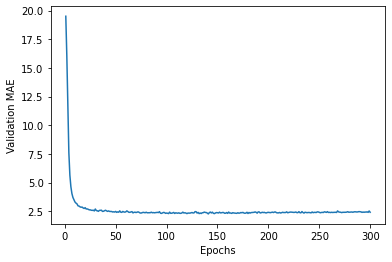

In [34]:
plt.ion()
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()
plt.ioff()


It may be a bit hard to see the plot due to scaling issues and relatively high variance. (Lecturer note: the variance dropped a _lot_ after changing the batch size to 16. So if you wish to see more variance, run the training step with batch size of one.)

Let's:
* Omit the first 10 data points, which are on a different scale from the rest of the curve.
* Replace each point with an [exponential moving average](https://en.wikipedia.org/wiki/Moving_average) of the previous points, to obtain a smooth curve.

In [36]:
# Corrected the smoothing formula to be in line with Wikipedia
# Code should also be a bit faster (though it doesn't really matter here)
def smooth_curve(points, alpha=0.1):
    smoothed_points = np.copy(points) # esp. [0] is "right"
    for i in range(1, len(points)):
        smoothed_points[i] = alpha * points[i] + (1.0 - alpha) * smoothed_points[i-1]
    return smoothed_points

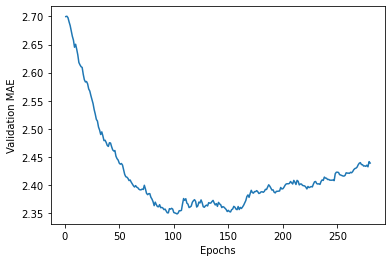

In [37]:
# dropping first 20 seems to give even clearer visualization
smooth_mae_history = smooth_curve(average_mae_history[20:])
plt.ion()
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()
plt.ioff()


According to this plot, it seems that validation MAE stops improving significantly after 80 (130?) epochs.
Past that point, we start overfitting.

Once we are done tuning other parameters of our model
(besides the number of epochs, we could also adjust the size of the hidden layers),
we  can train a final "production" model on all of the training data, with the best parameters,
then look at its performance on the test data:

In [38]:
# Get a fresh, compiled model.
model = build_model(input_size)

# Train it on the entirety of the data.
model.fit(train_data_rescaled, train_targets, epochs=130, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data_rescaled, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 14.8854 - mae: 2.5142


In [39]:
print(test_mae_score)

2.5141732692718506


We are still off by about \$2,550.

## Wrapping up


Here's what you should take away from this example:

* Regression is done using different loss functions from classification; Mean Squared Error (MSE) is a commonly used loss function for 
regression.
* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally the concept of "accuracy" 
does not apply for regression. A common regression metric is Mean Absolute Error (MAE).
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-Fold validation is a great way to reliably evaluate a model.
* When little training data is available, it is preferable to use a small network with very few hidden layers (typically only one or two), 
in order to avoid severe overfitting.

This example concludes our series of three introductory practical examples. You are now able to handle common types of problems with vector data input:

* Binary (2-class) classification.
* Multi-class, single-label classification.
* Scalar regression.
